# Rips Complex Tutorial
This is a quick Rips Filtration tutorial used to illustrate options provided in BATS.py.

In [1]:
import bats
import numpy as np
import matplotlib.pyplot as plt
import scipy.spatial.distance as distance
import bats
import time

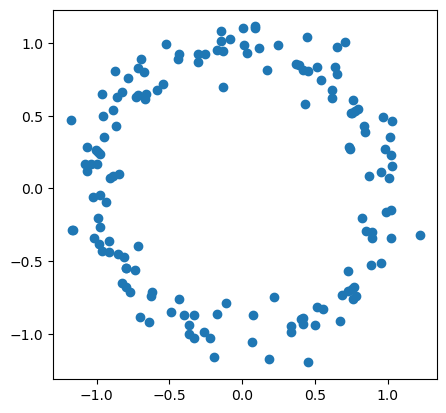

In [2]:
# first, generate a circle
np.random.seed(0)

n = 150
X = np.random.normal(size=(n,2))
X = X / np.linalg.norm(X, axis=1).reshape(-1,1)
X = X + np.random.normal(size=(n,2), scale = 0.1 )
fig = plt.scatter(X[:,0], X[:,1])
fig.axes.set_aspect('equal')
plt.savefig('figures/RipsEx_data.png')
plt.show()

Rips filtrations are commonly used in conjunction with persistent homology to create features for finite dimensional metric spaces (point clouds). Given a metric space $(X, d)$, a Rips complex consists of simplices with a maximum pairwise distance between vertices is less than some threshold $r$:

$$
X_r = \{(x_0,\dots,x_k) \mid x_i\in X, d(x_i,x_j) \le r\}.
$$

A Rips filtration is a filtration of Rips complexes $X_r \subseteq X_s$ if $r \le s$.

In [3]:
# compute pairwise distances
D = distance.squareform(distance.pdist(X))

# Rips complex for full metric space
# ie., threshold r = infinity now
F = bats.LightRipsFiltration(bats.Matrix(D), np.inf, 2)

# compute with F2 coefficents
t0 = time.monotonic()
R = bats.reduce(F, bats.F2())
t1 = time.monotonic()
print("time of compute persistent homology: {} sec.".format(t1-t0))

time of compute persistent homology: 2.9647895510006492 sec.


Now you are able to see persistent diagrams.

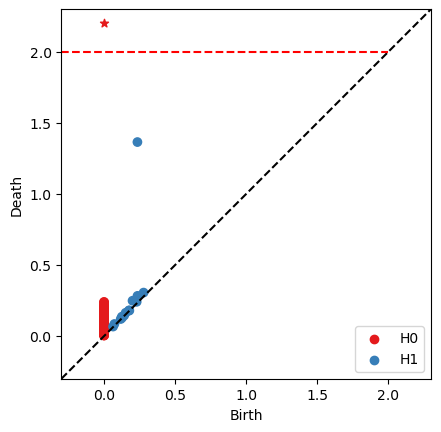

In [4]:
# find persistence pairs at each dimension
ps = []
for d in range(R.maxdim()):
    ps.extend(R.persistence_pairs(d))

# Draw persistent diagram
# 'tmax' is the axis maixmum value
fig, ax = bats.persistence_diagram(ps, tmax = 2.0)
plt.show()

## Efficient Computation 
The number of simplices in Rips filtrations quickly grows with the size of the data set, and much effort has gone into developing efficient algorithms for computing persistent homology of Rips filtrations. 

### Construction optimization
The first method that has been applied in several high-performance packages for Rips computations is to stop a filtration at the enclosing ***radius*** of the metric space, at which point the complex becomes contractible, which can reduce the total number of simplices in the filtration considerably without changing persistent homology.

In [5]:
# Two ways to find Enclosing Radius
r_enc = np.min(np.max(D, axis=0))
print("enclosing radius = {}".format(r_enc))

r_enc = bats.enclosing_radius(bats.Matrix(D))
print("enclosing radius = {}".format(r_enc))

enclosing radius = 1.8481549465930773
enclosing radius = 1.8481549465930773


In [6]:
# Rips complex up to enclosing radius
t0 = time.monotonic()
F_enc = bats.LightRipsFiltration(bats.Matrix(D), r_enc, 2)
t1 = time.monotonic()
print("construction time: {} sec.".format(t1-t0))

# compute with F2 coefficents
t0 = time.monotonic()
R_enc = bats.reduce(F_enc, bats.F2())
t1 = time.monotonic()
print("reduction time: {} sec.".format(t1-t0))

construction time: 0.07883952199881605 sec.
reduction time: 1.04050104900125 sec.


You can see the obvious improvement with about 2x speedup.

### Algorithm optimization

There are also many efficent algorithms provided in BATS.py:

* [Clearing/Compression](https://arxiv.org/abs/1303.0477): two options without basis returned.
* [Cohomology](https://arxiv.org/abs/1107.5665): faster on some filtrations.
* [Update Persistence](https://arxiv.org/abs/2108.05022): suitable when there are several similar datasets needed to be computed PH (e.g., optimization on persistence penalty).  
* Extra Reduction: perform extra reduction to eliminate nonzeros even after pivot has been found.  Performs
* Combinations of the above options

In [7]:
def time_BATS_flags(X, flags=(bats.standard_reduction_flag(), bats.compute_basis_flag())):
    
    t0 = time.monotonic()
    D = distance.squareform(distance.pdist(X))
    r_enc = bats.enclosing_radius(bats.Matrix(D))
    F_enc = bats.LightRipsFiltration(bats.Matrix(D), r_enc, 2)
    t0a = time.monotonic()
    R = bats.reduce(F_enc, bats.F2(), *flags)
    t1 = time.monotonic()
    print("{:.3f} sec.\t{:.3f} sec".format(t1 - t0a, t1 - t0))

In [8]:
flags = [
    (bats.standard_reduction_flag(), bats.compute_basis_flag()),
    (bats.standard_reduction_flag(),),
    (bats.standard_reduction_flag(), bats.clearing_flag()),
    (bats.standard_reduction_flag(), bats.compression_flag()),
    (bats.extra_reduction_flag(), bats.compute_basis_flag()),
    (bats.extra_reduction_flag(),),
    (bats.extra_reduction_flag(), bats.clearing_flag()),
    (bats.extra_reduction_flag(), bats.compression_flag()),
]
labels = [
    "standard w/ basis\t",
    "standard w/ no basis\t",
    "standard w/ clearing\t",
    "standard w/ compression\t",
    "extra w/ basis\t\t",
    "extra w/ no basis\t",
    "extra w/ clearing\t",
    "extra w/ compression\t"
]

print("flags\t\t\tReduction time\tTotal Time")
for flag, label in zip(flags, labels):
    print("{}".format(label),end=' ')
    time_BATS_flags(X, flag)

flags			Reduction time	Total Time
standard w/ basis	 1.019 sec.	1.117 sec
standard w/ no basis	 0.521 sec.	0.602 sec
standard w/ clearing	 0.519 sec.	0.607 sec
standard w/ compression	 0.492 sec.	0.577 sec
extra w/ basis		 0.905 sec.	0.985 sec
extra w/ no basis	 0.301 sec.	0.386 sec
extra w/ clearing	 0.304 sec.	0.388 sec
extra w/ compression	 0.184 sec.	0.268 sec


In [9]:
# add some noise to the original datasets 
# to create a similar datasets to show the performance of update persistence
X2 = X + np.random.normal(size=(n,2), scale = 0.001)

In [10]:
# PH computation on X1
D = distance.squareform(distance.pdist(X))
r_enc = bats.enclosing_radius(bats.Matrix(D))
F_X = bats.LightRipsFiltration(bats.Matrix(D), r_enc, 2)
R = bats.reduce(F_X, bats.F2())

# PH computation on X2 by update persistence on X1
t0 = time.monotonic()
D2 = distance.squareform(distance.pdist(X2))
r_enc2 = bats.enclosing_radius(bats.Matrix(D2))
F_Y = bats.LightRipsFiltration(bats.Matrix(D2), r_enc2, 2) # generate a RipsFiltration
UI = bats.UpdateInfoLightFiltration(F_X, F_Y) # find updating information
R.update_filtration_general(UI)
t1 = time.monotonic()
print("compute PH by updating persistence needs: {:.3f} sec.".format(t1 - t0))

compute PH by updating persistence needs: 0.492 sec.


Advantanges of updating persistence over the other options:

1. still keep the basis information;

2. with a comparable speedup with other optimization algorithms.